## Linear Regression Analysis and ANOVA

In [1]:
# Import relevant libraries

import pandas as pd
import datetime
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import f

## 3.1 Construct a full regression model

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Function to extract data from a cell using the data attribute
def extract_data(cell):
    return cell.data

# Data Loading
final_df = pd.read_csv('S&P100_Data.csv')  # Stock data
sp_100 = pd.read_csv('^OEX.csv')  # S&P100 index data

# Data Cleaning
final_df.set_index('Date', inplace=True)
sp_100.set_index('Date', inplace=True)

final_df.drop(columns=['METV', 'MLSS'], inplace=True)  # Drop columns with many missing values

# Cleaning and Preprocessing S&P100 Data
sp_100 = sp_100[['Adj Close']].rename(columns={'Adj Close': 'SP_100'})
sp_100['Returns'] = sp_100.pct_change() * 100
sp_100.dropna(inplace=True)

# Extract Response Variable
sp_100_ret = np.array(sp_100['Returns']).reshape(-1, 1)

# Multiple Linear Regression Model
X = sm.add_constant(final_df)  # Add constant term
model = sm.OLS(sp_100_ret, X).fit()  # Train the model

# Extract Model Summary
full_model_summary = model.summary()

# Reformatting Summary Table
df_full_model = pd.DataFrame(full_model_summary.tables[1][1:], columns=full_model_summary.tables[1][0])
df_full_model.columns = df_full_model.columns.astype(str)
df_full_model.rename(columns={df_full_model.columns[0]: 'Name'}, inplace=True)
df_full_model.set_index('Name', inplace=True)
df_full_model.index = [str(cell.data) for cell in df_full_model.index]
df_full_model = df_full_model.applymap(extract_data).astype(float)

# Extract Coefficients and Names
elem1 = df_full_model.index.tolist()
elem2 = df_full_model.iloc[:, 0].tolist()

# Prepare Output String
string_full_model = f"SP_100 ~ {elem2[0]}"

for name, coef in zip(elem1[1:], elem2[1:]):
    string_full_model += f" + {name} * {coef}"
    
string1 = f"SP_100 ~ "    
for count, name in enumerate(elem1[1:]):
    if count ==0:
        string1 += f" {name}"
    else:
        string1 += f" + {name}"        
    
print(string_full_model)

SP_100 ~ -0.0296 + ORCL * 0.012 + MSFT * 0.0639 + HON * 0.0026 + KO * 0.009 + XOM * 0.0155 + GD * -0.0039 + GE * 0.0058 + CHTR * -0.0016 + GM * 0.0039 + IBM * 0.0015 + META * 0.0308 + ABBV * 0.006 + PEP * 0.0175 + MO * 0.0022 + COP * 0.0076 + AMGN * 0.012 + CVX * 0.0175 + GOOG * 0.0047 + AAPL * 0.0852 + TXN * 0.0114 + CVS * 0.0096 + BH * 0.0015 + RTX * -0.0016 + PG * 0.0206 + SO * -0.0095 + CAT * 0.0034 + CL * 0.0056 + BMY * 0.0038 + WBA * -0.0037 + BA * 0.0112 + ABT * 0.0057 + LMT * 0.0094 + EXC * 0.0085 + PFE * 0.0128 + EMR * 0.0049 + JNJ * 0.0263 + MMM * -5.842e-05 + MRK * 0.0128 + NEE * 0.0194 + F * 0.0062 + DIS * 0.0227 + DUK * -0.0052 + WFC * 0.0167 + MCD * 0.0085 + JPM * 0.0292 + UNP * 0.0092 + TGT * 0.0067 + BK * 0.0048 + DHR * 0.0163 + LLY * 0.0143 + WMT * 0.0109 + NKE * 0.0075 + AXP * 0.004 + INTC * 0.0132 + BAC * 0.0091 + MDT * -0.0009 + FDX * 0.0026 + AMD * 0.0028 + LOW * 0.009 + TMO * 0.0155 + VZ * 0.0163 + T * 0.0141 + USB * -0.0143 + HD * 0.0076 + AIG * -0.0004 + MS * 0.

## 3.2 Use partial F-statistics and backward elimination to select variables from the full regression model in 1. Write down the selected model.

### Model Selected using Backward Elimination

In [3]:
# Perform Backward Elimination to Select Significant Features
def backward_elimination(full_model_df, X_data, y_data):
    df_selected_model = full_model_df.copy()
    while True:
        df_significant = df_selected_model.sort_values(by='P>|t|', ascending=False)
        max_p_value = df_significant.iloc[0]['P>|t|']
        
        if max_p_value > 0.05:
            variable_to_remove = df_significant.index[0]
            df_significant.drop([variable_to_remove], inplace=True)
            
            selected_cols = df_significant.index.tolist()
            if 'const' in selected_cols:
                selected_cols.remove('const')
                
            X_selected = sm.add_constant(X_data[selected_cols])
            selected_model = sm.OLS(y_data, X_selected).fit()
            selected_model_summary = selected_model.summary()

            df_selected_model = pd.DataFrame(selected_model_summary.tables[1][1:], columns=selected_model_summary.tables[1][0])
            df_selected_model.columns = [col.data for col in df_selected_model.columns]
            df_selected_model.rename(columns={'': 'Name'}, inplace=True)
            df_selected_model.set_index('Name', inplace=True)
            df_selected_model.index = [index.data for index in df_selected_model.index]
            df_selected_model = df_selected_model.applymap(extract_data).astype(float)
        else:
            break
            
    return df_selected_model, selected_model

df_selected_model, selected_model = backward_elimination(df_full_model, final_df, sp_100_ret)

# Generate Summary String for Selected Model
elem1 = df_selected_model.index.tolist()
elem2 = df_selected_model.iloc[:, 0].tolist()

string_list = [f"{var} * {coef}" for var, coef in zip(elem1, elem2)]
string_selected_model = f"{elem2[0]} + {' + '.join(string_list[1:])}"
string_selected_model = f"SP_100 ~ {string_selected_model}"

string2 = f"SP_100 ~ "    
for count, name in enumerate(elem1[1:]):
    if count ==0:
        string2 += f" {name}"
    else:
        string2 += f" + {name}"  

print(string_selected_model)

SP_100 ~ -0.0296 + EMR * 0.0062 + COF * 0.0053 + ABT * 0.0062 + KO * 0.0089 + BKNG * 0.0041 + BAC * 0.0104 + MS * 0.012 + AVGO * -0.005 + EXC * 0.0075 + AMT * 0.0072 + AMD * 0.0028 + GILD * 0.0067 + ABBV * 0.0065 + MCD * 0.01 + CVS * 0.0083 + GE * 0.0059 + NFLX * 0.0045 + LMT * 0.0084 + SO * -0.0127 + NKE * 0.0081 + COP * 0.0078 + META * 0.031 + BLK * 0.0239 + PEP * 0.0192 + MRK * 0.013 + ADBE * 0.0178 + PFE * 0.0126 + LOW * 0.0126 + QCOM * 0.0167 + UNP * 0.011 + VZ * 0.0151 + LLY * 0.0149 + XOM * 0.0151 + CMCSA * 0.0174 + UNH * 0.0157 + MET * 0.0138 + DHR * 0.0174 + UPS * 0.0159 + TMO * 0.0156 + NVDA * 0.0095 + AMZN * 0.0387 + BA * 0.0115 + ACN * 0.0169 + PG * 0.0238 + JPM * 0.0306 + TXN * 0.013 + F * 0.0085 + AAPL * 0.0855 + V * 0.0131 + NEE * 0.0183 + CRM * 0.0073 + GOOGL * 0.0451 + COST * 0.0235 + JNJ * 0.0272 + T * 0.0149 + USB * -0.0141 + CVX * 0.018 + INTC * 0.0138 + WMT * 0.0112 + WFC * 0.0168 + TGT * 0.0069 + ORCL * 0.0141 + AMGN * 0.0124 + DIS * 0.0234 + MSFT * 0.064 + TSLA *

## 3.3 Compare the full and selected models. Summarize your comparison in an ANOVA table.

## Comparison of Selected and Full Models
1. F-Statistic for full regression model ~ 1846 with dof1 = 97 & dof2 = 1916, P(F-statistic) = 0 and F statistic for selected regression model ~ 2819 with dof1 = 52 & dof2 = 1961, P(F-statistic) = 0 which shows both models are statistically significant. 
2. There isn't any major difference in the adjusted R-squared values for both models, indicating that both models fit the data equally well
3. The AIC and BIC of full regression model is lower than the selected model, indicating a better model fit for the full regression model.

In [4]:
sp_100_df = pd.DataFrame(sp_100_ret, columns = ['SP_100'], index = final_df.index)
cols = df_selected_model.index[1:]


# Concatenating S&P 100 data with the full and selected datasets
combined_full_model = pd.concat([sp_100_df, final_df], axis=1)
combined_selected_model = pd.concat([sp_100_df, final_df[cols]], axis=1)  # 'cols' are the selected features

# Performing ANOVA for the Full Model
full_model_ols = ols(formula=string1, data=combined_full_model).fit()
anova_full_model = sm.stats.anova_lm(full_model_ols)
print('\nANOVA results for Full Model:')
print(anova_full_model)

# Performing ANOVA for the Selected Model
selected_model_ols = ols(formula=string2, data=combined_selected_model).fit()
anova_selected_model = sm.stats.anova_lm(selected_model_ols)
print('\nANOVA results for Selected Model:')
print(anova_selected_model)

# Calculate Residual Sum of Squares (RSS) for both models
RSS_full = anova_full_model.iloc[-1, 1]
RSS_selected = anova_selected_model.iloc[-1, 1]

# Calculate number of predictors for both models
p = anova_selected_model.shape[0] - 1  # Number of predictors in the selected model
k = anova_full_model.shape[0] - 1  # Number of predictors in the full model

# Number of data points
T = final_df.shape[0]

dfn = 45
dfd = 1916

# Calculate F-statistic
F_statistic = (RSS_selected - RSS_full) * (T - k - 1) / ((k - p) * RSS_full)
print("\nCalculated F-statistic:", F_statistic)
print("p-value: ", f.sf(F_statistic, dfn = 45, dfd = 1916))


ANOVA results for Full Model:
              df       sum_sq      mean_sq             F        PR(>F)
ORCL         1.0  1301.869373  1301.869373  81324.061460  0.000000e+00
MSFT         1.0   902.044776   902.044776  56348.160807  0.000000e+00
HON          1.0   235.743128   235.743128  14726.199926  0.000000e+00
KO           1.0    38.846780    38.846780   2426.647383  0.000000e+00
XOM          1.0    49.261116    49.261116   3077.201191  0.000000e+00
...          ...          ...          ...           ...           ...
V            1.0     0.045679     0.045679      2.853450  9.134076e-02
UNH          1.0     0.513566     0.513566     32.080972  1.702722e-08
AVGO         1.0     0.046705     0.046705      2.917500  8.778552e-02
TSLA         1.0     1.749192     1.749192    109.267009  6.541237e-25
Residual  1916.0    30.672124     0.016008           NaN           NaN

[98 rows x 5 columns]

ANOVA results for Selected Model:
              df       sum_sq      mean_sq             F   

## 3.4 For the selected regression model in (b), perform residual diagnostics.

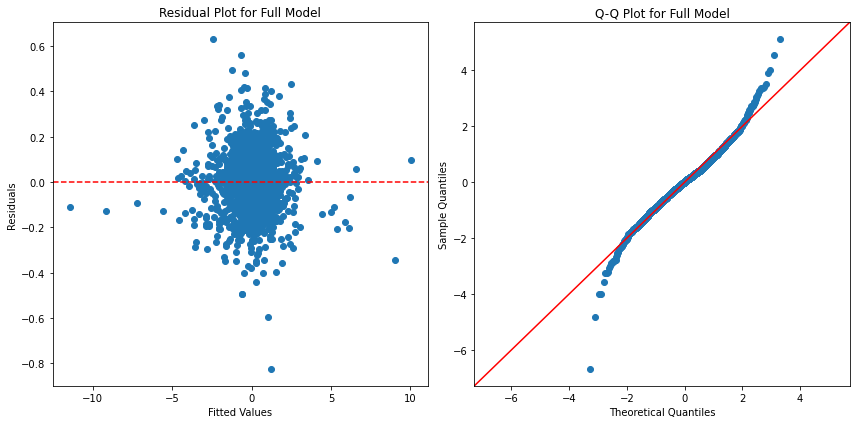

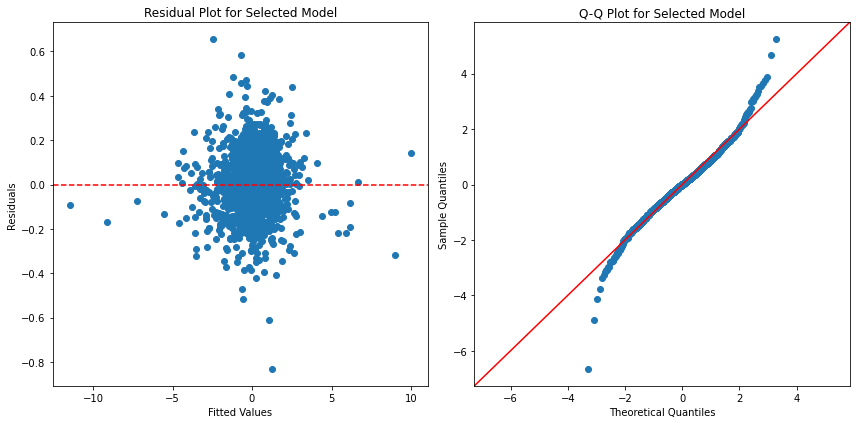

In [5]:
# Residual Plots And QQ Plots for full model

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Residual Plot
ax1.scatter(model.fittedvalues, model.resid)
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residual Plot for Full Model')
ax1.axhline(y=0, color='r', linestyle='--')

# QQ Plot
sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax2)
ax2.set_title("Q-Q Plot for Full Model")

# Show the plots
plt.tight_layout()
plt.show()

# Residual plots and QQ plots for selected model

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Residual Plot
ax1.scatter(selected_model.fittedvalues, selected_model.resid)
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residual Plot for Selected Model')
ax1.axhline(y=0, color='r', linestyle='--')

# QQ Plot
sm.graphics.qqplot(selected_model.resid, dist=stats.norm, line='45', fit=True, ax=ax2)
ax2.set_title("Q-Q Plot for Selected Model")

# Show the plots
plt.tight_layout()
plt.show()

### From the residual plots for both the models we can observe that the residuals are randomly scattered around the point zero with presense of a few outliers. The QQ plots also verify the same results with most residuals lying on the Y=X axis with a few outliers indicating heavier tails at the extremes.

## 3.5 If you can only use at most five stocks to track the daily S&P100 returns, describe your model selection procedure and your constructed model.

### The step-wise forward selection procedure was employed to identify a maximum of five stocks for the OLS regression analysis. This method begins with an empty model and selects the first stock based on the lowest AIC from the regression analysis. With each subsequent step, an additional stock is incorporated into the model. This inclusion is determined by the combination of stocks that yields the lowest AIC when used as explanatory variables in the OLS regression model.

In [6]:
all_stocks = final_df.columns.to_list()

stock_list = []

current_aic, least_aic = float('inf'), float('inf')  # Initialize with a high value

while current_aic == least_aic and len(stock_list) < 5:  
    ls = []

    for candidate in all_stocks:
        string = "{} ~ {} + 1".format(sp_100_df.columns[0], ' + '.join(stock_list + [candidate]))
        score = smf.ols(string, combined_full_model).fit().aic
        ls.append((score, candidate))

    ls.sort()
    least_aic, best_aic = ls[0]

    if current_aic > least_aic:
        all_stocks.remove(best_aic)
        stock_list.append(best_aic)
        current_aic = least_aic

string = "{} ~ {} + 1".format(sp_100_df.columns[0], ' + '.join(stock_list))
five_stock_model = smf.ols(string, combined_full_model).fit()

print(five_stock_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 SP_100   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     4951.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:24:35   Log-Likelihood:                -616.05
No. Observations:                2014   AIC:                             1244.
Df Residuals:                    2008   BIC:                             1278.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0289      0.007     -3.933      0.0